# Experimental Design
***
## Simulation

Import the necessary packages and code for simulating an experiment.

In [ ]:
%pip install hogben

In [5]:
%matplotlib inline

import numpy as np

from hogben.simulate import SimulateReflectivity

from refnx.reflect import SLD, ReflectModel

# Reduce size of plots for the notebook.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['figure.dpi'] = 100

Next, define the structure that we want to simulate. Here the structure has been defined using [refnx](https://refnx.readthedocs.io/).

In [9]:
# Defines a structure describing a simple sample.
air = SLD(0, name='Air')
FeOx = SLD(7.8, name='Surface oxide')(thick=20, rough=10)
Fe_H = SLD(7.9, name='H loaded Fe layer')(thick=500, rough=10)
Fe_substrate = SLD(8.02, name='Iron Substrate')(thick=0, rough=10)


pristine = air | FeOx | Fe_substrate
H_loaded = air | Fe_H | FeOx | Fe_substrate


# Convert the structure into a refnx model and add instrumental factors
pristine_model = ReflectModel(pristine)
loaded_model = ReflectModel(H_loaded)

for model in (pristine_model, loaded_model):
    model.scale = 1
    model.bkg = 1e-6  # background scattering
    model.dq = 2  # instrumental resolution


Here we see what the SLD profile of our simple structure looks like.

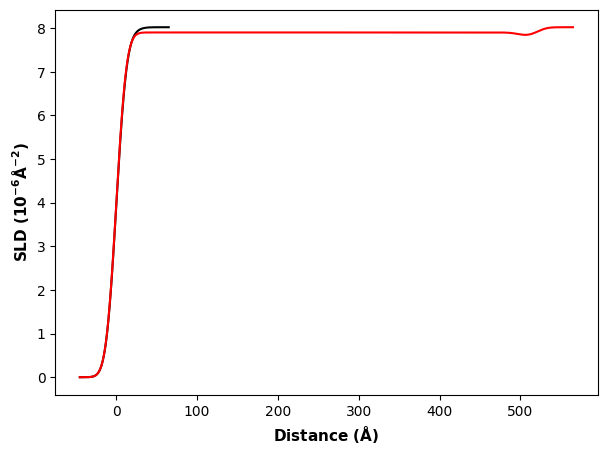

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(*pristine.sld_profile(), color='black')
ax.plot(*H_loaded.sld_profile(), color='red')
ax.set_xlabel('$\mathregular{Distance\ (\AA)}$', fontsize=11, weight='bold')
ax.set_ylabel('$\mathregular{SLD\ (10^{-6} \AA^{-2})}$', fontsize=11, weight='bold')
plt.show()

To simulate the structure, we need to define the counting times and number of points for each angle to simulate. We also specify the experimental scale factor, level of background noise and instrument resolution (in this case constant 2% $dQ/Q$).

In [15]:
angle_times = [(0.7, 100, 10),
               (2.0, 100, 500)] # (Angle, Points,ime)

instrument = 'OFFSPEC' # Options are 'INTER', 'OFFSPEC', 'POLREF' or 'SURF'


# Simulate the experiment.
pristine_data = SimulateReflectivity(pristine_model, angle_times, instrument).simulate()
loaded_data = SimulateReflectivity(loaded_model, angle_times, instrument).simulate()

We can now plot the simulated data together with the "true" model reflectivity. Note that this data is not stitched; the data from each individual angle has been plotted without any rebinning.

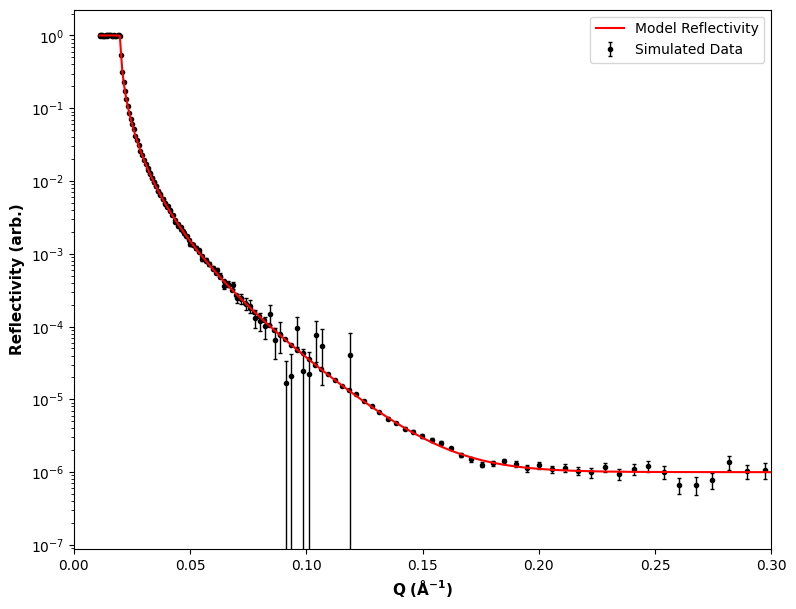

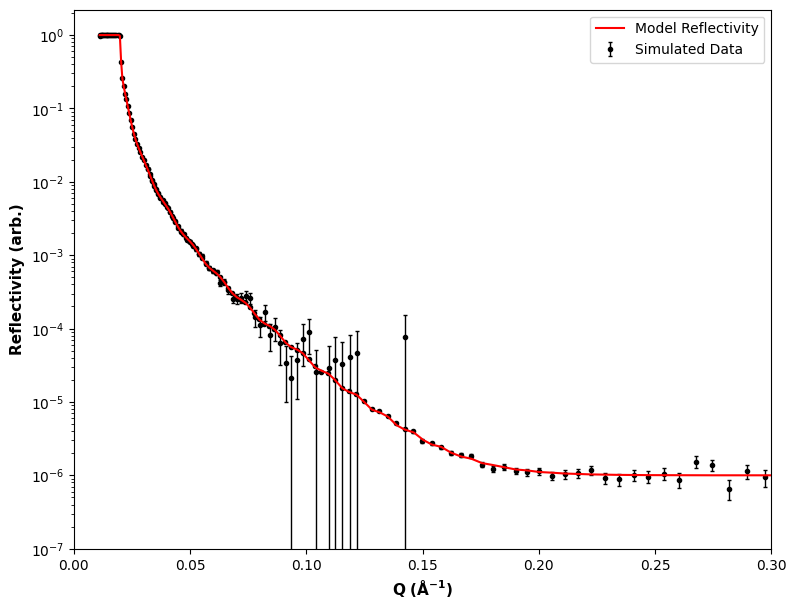

In [16]:
def plot_reflectivity(model, data):
    # Extract each column of the simulated `data`.
    q, r, dr, counts = data[0], data[1],  data[2], data[3]

    # Calculate the model reflectivity.
    r_model = SimulateReflectivity(model, angle_times, instrument).reflectivity(q)

    # Plot the model and simulated reflectivity against Q.
    fig = plt.figure(figsize=[9,7])
    ax = fig.add_subplot(111)

    # Model reflectivity.
    ax.plot(q, r_model, color='red', zorder=20, label='Model Reflectivity')

    # Simulated reflectivity
    ax.errorbar(q, r, dr, color='black', marker='o', ms=3, lw=0, elinewidth=1, capsize=1.5, label='Simulated Data')

    ax.set_xlabel('$\mathregular{Q\ (Å^{-1})}$', fontsize=11, weight='bold')
    ax.set_ylabel('Reflectivity (arb.)', fontsize=11, weight='bold')
    ax.set_yscale('log')
    ax.set_xlim(0, 0.3)
    ax.legend()
    plt.show()
    
plot_reflectivity(pristine_model, pristine_data)   
plot_reflectivity(loaded_model, loaded_data)

## This shows that we are not very sensitive to a change in the H content (I have simulated a change of 0.1 A^{-1}, which would correspond to a much larger than we expect H content.

### Instead we can look at the experiment where we have a film of Fe on Si (this is much easier to get very flat and smooth). We would then have a small change in the SLD of the layer, but a potentially more visible change in the thickness of the film.

In [51]:
thickness = 300  # Thickness of the Fe film in Angstroms
strain = 0.01  #Is this the right way to do this???

air = SLD(0, name='Air')
Fe = SLD(8.02, name='Fe film')(thick=thickness, rough=3)
Fe_H_film = SLD(7.99, name='H loaded Fe film')(thick=thickness*(1+strain), rough=3)
Si_substrate = SLD(2.07, name='Silicon Substrate')(thick=0, rough=3)



pristine_film = air | Fe | Si_substrate
H_loaded_film = air | Fe_H_film | Si_substrate


# Convert the structure into a refnx model and add instrumental factors
pristine_film_model = ReflectModel(pristine_film)
loaded_film_model = ReflectModel(H_loaded_film)

for model in (pristine_film_model, loaded_film_model):
    model.scale = 1
    model.bkg = 1e-6  # background scattering
    model.dq = 2  # instrumental resolution

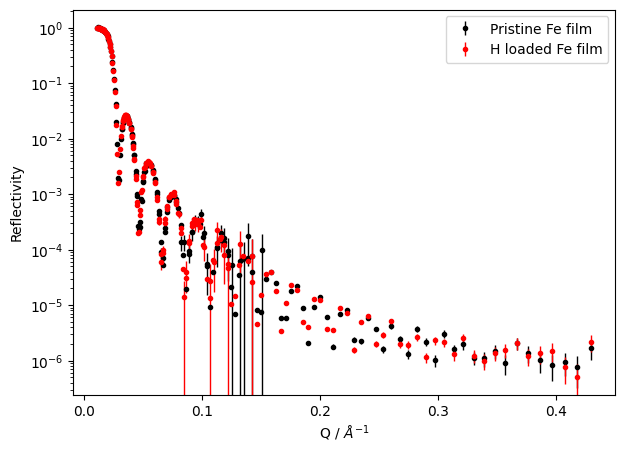

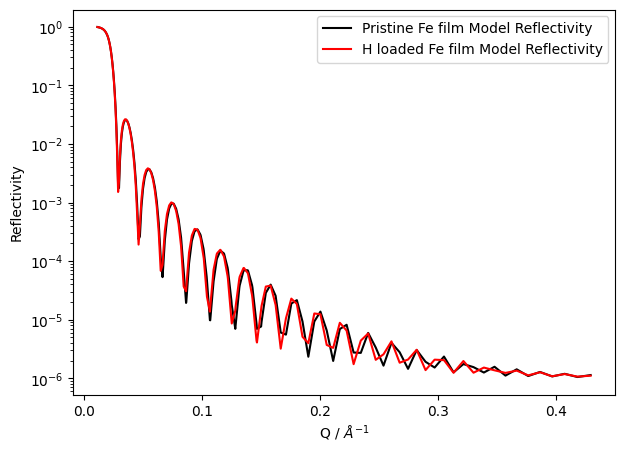

In [52]:
# Simulate the experiment.
pristine_film_data = SimulateReflectivity(pristine_film_model, angle_times, instrument).simulate()
loaded_film_data = SimulateReflectivity(loaded_film_model, angle_times, instrument).simulate()

q = pristine_film_data[0]

fig, ax = plt.subplots()
plt.errorbar(q, pristine_film_data[1], yerr=pristine_film_data[2], marker='o', ms=3, lw=0, elinewidth=1, color='black', label='Pristine Fe film')
plt.errorbar(q, loaded_film_data[1], yerr=loaded_film_data[2], marker='o', ms=3, lw=0, elinewidth=1, color='red', label='H loaded Fe film')
plt.yscale('log')
plt.xscale('linear')
plt.xlabel('Q / $\AA^{-1}$')
plt.ylabel('Reflectivity')
plt.legend();
plt.show()



fig, ax = plt.subplots()
ax.plot(q, pristine_film_model.model(q), color='black', zorder=20, label='Pristine Fe film Model Reflectivity')
ax.plot(q, loaded_film_model.model(q), color='red', zorder=20, label='H loaded Fe film Model Reflectivity')
plt.yscale('log')
plt.xscale('linear')
plt.xlabel('Q / $\AA^{-1}$')
plt.ylabel('Reflectivity')
plt.legend();
plt.show()



## We have a potentially measuranble difference, Pretty much all the change comes in the form of the thickness change of the film - changing the SLD does very little within reasonable limits. The differences are subtle but would show up if the measurement was one where we measure before and after the H loading.

### Open questions: 
    - If we only see the thickness change, is this at all useful in terms of being able to get out a H content?
    - Changing the thickness would probably change our sensitivity, but would be the way to get a feel for the H ingress so it is worth pursuing?
    - It is a difficult (though possible) experiment. I have made assumtions that nothing else in the system changes. Feel free to have a play adding layers or changing roughnesses between the pristine and loaded. However, I have no idea if this would give useful informaion to you at all??